<a href="https://colab.research.google.com/github/w1767/MSc-project/blob/main/Final_VIX_Volatility_GARCH_MC_LSTM_SVM_RF_7_jan_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Volatility Prediction Using GARCH, Monte Carlo, LSTM, SVM and Random Forest

In [1]:

!pip install matplotlib==3.1.3


     |████████████████████████████████| 13.1 MB 4.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [75]:
!pip install arch
!pip install tensor
!pip install tensorflow
!pip install statsmodels
!pip install keras
!pip install sklearn
import tensorflow
import keras
import sklearn
from pathlib import Path
from datetime import datetime, timedelta
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
from arch import arch_model
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import os
import glob
import csv
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.ensemble import RandomForestRegressor
from keras.models import load_model
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error

### Reading the dataset from your local directory

In [ ]:
#os.chdir('D:\GU_Project') 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/Master thesis/VIX.csv"

In [5]:
VI_db=pd.read_csv("/content/drive/MyDrive/Master thesis/VIX.csv")

In [10]:
VI_db

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/1990,17.240000,17.240000,17.240000,17.240000,17.240000,0
1,03/01/1990,18.190001,18.190001,18.190001,18.190001,18.190001,0
2,04/01/1990,19.219999,19.219999,19.219999,19.219999,19.219999,0
3,05/01/1990,20.110001,20.110001,20.110001,20.110001,20.110001,0
4,08/01/1990,20.260000,20.260000,20.260000,20.260000,20.260000,0
...,...,...,...,...,...,...,...
7929,22/06/2021,17.910000,18.320000,15.760000,16.660000,16.660000,0
7930,23/06/2021,16.250000,16.840000,14.860000,16.320000,16.320000,0
7931,24/06/2021,15.990000,16.049999,14.190000,15.970000,15.970000,0
7932,25/06/2021,16.040001,16.170000,15.210000,15.620000,15.620000,0


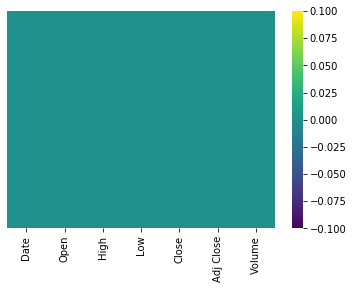

In [7]:
import seaborn as sns
# Checking the Missing Values
sns.heatmap(VI_db.isnull(), yticklabels=False, cmap= "viridis")

### Data type formating of the required features 

In [13]:
VI_db['Date']= pd.to_datetime(VI_db['Date'])

### Features preparations

In [14]:
VI_db['log_price'] = np.log(VI_db['Close'])

In [15]:
VI_db['pct_change'] = VI_db['log_price'].diff()

In [16]:
VI_db['stdev'] = VI_db['pct_change'].rolling(window=30, center=False).std()

In [17]:
VI_db['Volatility'] = VI_db['stdev']*(252**0.5)

### Display top 100 records

In [18]:
VI_db.head(100)

,Date,Open,High,Low,Close,Adj Close,Volume,log_price,pct_change,stdev,Volatility
0,1990-02-01,17.240000,17.240000,17.240000,17.240000,17.240000,0,2.847232,NaN,NaN,NaN
1,1990-03-01,18.190001,18.190001,18.190001,18.190001,18.190001,0,2.900872,0.053640,NaN,NaN
2,1990-04-01,19.219999,19.219999,19.219999,19.219999,19.219999,0,2.955951,0.055079,NaN,NaN
3,1990-05-01,20.110001,20.110001,20.110001,20.110001,20.110001,0,3.001217,0.045266,NaN,NaN
4,1990-08-01,20.260000,20.260000,20.260000,20.260000,20.260000,0,3.008648,0.007431,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,1990-05-17,17.270000,17.270000,17.270000,17.270000,17.270000,0,2.848971,-0.025159,0.069642,1.105535
96,1990-05-18,17.200001,17.200001,17.200001,17.200001,17.200001,0,2.844909,-0.004061,0.069416,1.101950
97,1990-05-21,16.719999,16.719999,16.719999,16.719999,16.719999,0,2.816606,-0.028304,0.069241,1.099169
98,1990-05-22,17.840000,17.840000,17.840000,17.840000,17.840000,0,2.881443,0.064838,0.070293,1.115870


### Set 'Date' as index

In [19]:
to_plt = VI_db.sort_values(by = 'Date').set_index('Date')

### Plot Volatility feature from the DataFrame

Text(0.5, 1.0, 'VIX Rolling Volatility considering 30 Time Periods with Standard Deviation Annualized')

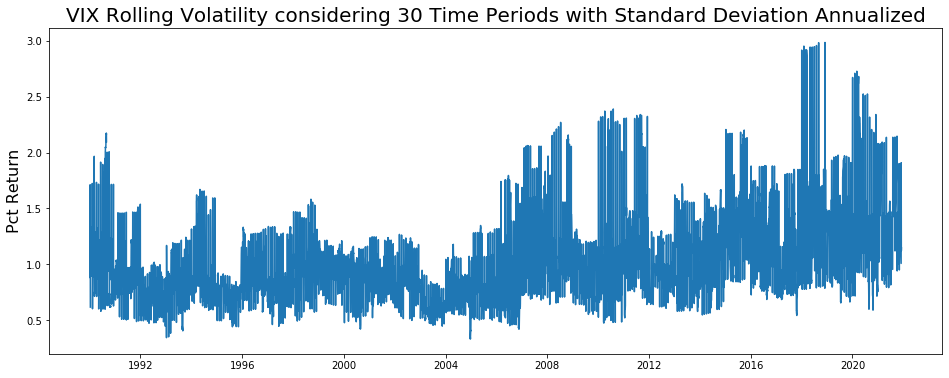

In [20]:
plt.figure(figsize=(16,6))
plt.plot(to_plt['Volatility'])
plt.ylabel('Pct Return', fontsize=16)
plt.title('VIX Rolling Volatility considering 30 Time Periods with Standard Deviation Annualized', fontsize=20)

In [21]:
df=to_plt.dropna()

In [22]:
vol = df['Volatility'] * 100

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7904 entries, 1990-01-03 to 2021-12-05
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        7904 non-null   float64
 1   High        7904 non-null   float64
 2   Low         7904 non-null   float64
 3   Close       7904 non-null   float64
 4   Adj Close   7904 non-null   float64
 5   Volume      7904 non-null   int64  
 6   log_price   7904 non-null   float64
 7   pct_change  7904 non-null   float64
 8   stdev       7904 non-null   float64
 9   Volatility  7904 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 679.2 KB


### To Check if there is null value in any of the column

In [24]:
df.isnull().any() 

Open          False
High          False
Low           False
Close         False
Adj Close     False
Volume        False
log_price     False
pct_change    False
stdev         False
Volatility    False
dtype: bool

In [25]:
## Replacing the missing values with df.mean()
VI_db.replace([np.inf, -np.inf], np.nan, inplace=True)
VI_db.fillna(df.mean(), inplace=True)

### Performing the ADF test to identify if the return series is stationary or non-stationary

In [26]:
result = adfuller(df.Volatility)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.631603
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Volatility Prediction using GARCH(3,1)

In [27]:
GARCH_Mod = arch_model(vol, vol='Garch', p=3, o=0, q=1, dist='Normal')

### GARCH Summary

In [28]:
res = GARCH_Mod.fit(disp='off')
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -38027.9
Distribution:                  Normal   AIC:                           76067.8
Method:            Maximum Likelihood   BIC:                           76109.7
                                        No. Observations:                 7904
Date:                Wed, Jan 05 2022   Df Residuals:                     7903
Time:                        16:23:05   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            88.8885      0.975     91.129      0.000 [ 86.977, 90.800]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega        110.8320     42.483      2.609  9.084e-03 [ 27.567,1.941e+02]
alpha[1]       0.4793  5.057e-02      9.476  2.638e-21   [  0.380,  0.578]
alpha[2]   1.0561e-09      0.101  1.049e-08      1.000   [ -0.197,  0.197]
alpha[3]   2.7648e-10  8.964e-02  3.084e-09      1.000   [ -0.176,  0.176]
beta[1]        0.5048      0.175      2.890  3.856e-03   [  0.162,  0.847]
==========================================================================

Covariance estimator: robust
"""

### Creating Forecasted Volatility feature

In [29]:
df['forecast_vol'] = 0.1 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]'])

In [30]:
df['Volatility'].head(20)

Date
1990-01-03    0.893589
1990-01-05    1.334283
1990-01-06    0.881965
1990-01-08    1.712147
1990-01-10    0.947622
1990-01-11    0.618401
1990-02-03    0.895341
1990-02-04    1.017414
1990-02-05    1.335973
1990-02-07    1.268275
1990-02-08    1.723761
1990-02-10    0.943967
1990-02-11    0.603746
1990-02-13    1.072026
1990-02-14    1.091692
1990-02-15    1.133728
1990-02-16    1.136526
1990-02-20    1.166584
1990-02-21    1.144704
1990-02-22    1.157712
Name: Volatility, dtype: float64

In [31]:
pip install openpyxl

In [32]:
df['Volatility'].to_excel('g_a.xlsx')# to export actual value of GARCH MODEL

In [33]:
df['forecast_vol'].to_excel('g_p.xlsx')# to export predicted value of GARCH MODEL

### Ploting Actual Volatility Vs Forecasted Volatility

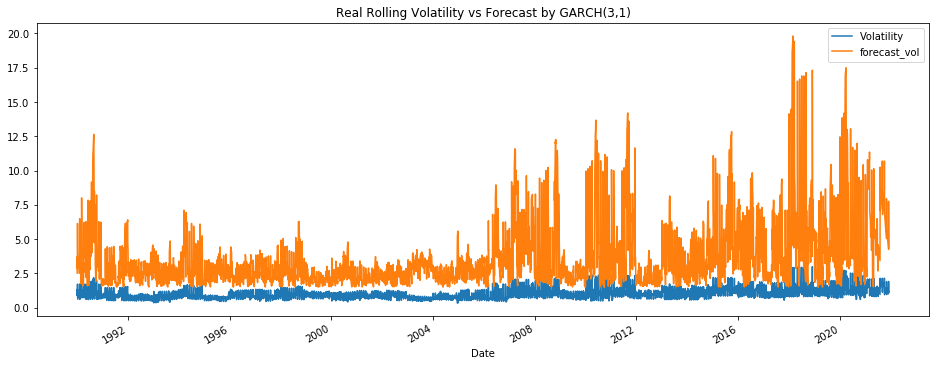

In [34]:
plt.figure(figsize=(16,6))
df["Volatility"].plot()
df["forecast_vol"].plot()
plt.title("Real Rolling Volatility vs Forecast by GARCH(3,1)")
plt.legend()
plt.show()

### Calculating RMSE value for GARCH Model

In [35]:
print('RMSE calculated for GARCH(3,1) model:', np.sqrt(metrics.mean_squared_error(df.loc[df.index[1000:], 'Volatility'], df.loc[df.index[1000:], 'forecast_vol'])))

RMSE calculated for GARCH(3,1) model: 3.235846319536613


In [36]:
print('MAE calculated for GARCH(3,1) model:', MAE(df.loc[df.index[1000:], 'Volatility'], df.loc[df.index[1000:], 'forecast_vol']))

MAE calculated for GARCH(3,1) model: 2.4903838837070387


In [39]:
print('MAPE calculated for GARCH:',mean_absolute_percentage_error(df.loc[df.index[1000:], 'Volatility'], df.loc[df.index[1000:], 'forecast_vol']))

MAPE calculated for GARCH: 2.4254284138806548


## Volatility Prediction using LSTM

In [40]:
training_set = df.iloc[:, 9:10].values
X_train = []
y_train = []
for i in range(100, df.shape[0]):
    X_train.append(training_set[i-100:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [41]:
df.shape

(7904, 11)

### Preparing X_train for RNN using LSTM

In [42]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Creating RNN with LSTM

In [43]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
opt = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)
regressor.compile(optimizer = 'opt', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
244/244 [==============================] - 43s 145ms/step - loss: 0.1775
Epoch 2/50
244/244 [==============================] - 35s 143ms/step - loss: 0.1087
Epoch 3/50
244/244 [==============================] - 35s 143ms/step - loss: 0.1072
Epoch 4/50
244/244 [==============================] - 34s 140ms/step - loss: 0.1011
Epoch 5/50
244/244 [==============================] - 35s 144ms/step - loss: 0.0944
Epoch 6/50
244/244 [==============================] - 34s 141ms/step - loss: 0.0877
Epoch 7/50
244/244 [==============================] - 35s 142ms/step - loss: 0.0840
Epoch 8/50
244/244 [==============================] - 34s 140ms/step - loss: 0.0821
Epoch 9/50
244/244 [==============================] - 34s 140ms/step - loss: 0.0769
Epoch 10/50
244/244 [==============================] - 34s 140ms/step - loss: 0.0764
Epoch 11/50
244/244 [==============================] - 33s 136ms/step - loss: 0.0744
Epoch 12/50
244/244 [==============================] - 33s 136ms/step - lo

In [46]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 10)           480       
                                                                 
 dropout (Dropout)           (None, 100, 10)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 10)           840       
                                                                 
 dropout_1 (Dropout)         (None, 100, 10)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 10)           840       
                                                                 
 dropout_2 (Dropout)         (None, 100, 10)           0         
                                                                 
 lstm_3 (LSTM)               (None, 10)                8

In [53]:
regressor.evaluate(X_train, y_train, verbose=0, batch_size = 32)

0.0522066168487072

In [73]:
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
#Initialising the RNN
def lstm_model(): regressor = Sequential() regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))) regressor.add(Dropout(0.2)) regressor.add(LSTM(units=50, return_sequences=True)) regressor.add(Dropout(0.2)) regressor.add(LSTM(units=50)) regressor.add(Dropout(0.2)) regressor.add(Dense(units=1)) regressor.compile(optimizer='adam', loss='mean_squared_error') return regressor

regressor = KerasRegressor(build_fn=lstm_model, epochs=100, batch_size=16, verbose=0)

regressor.fit(X_train, y_train)

In [76]:
#Grid Search
from sklearn.model_selection import GridSearchCV units = [30, 50, 70, 90] dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid'] batch_size = [8, 16, 32, 48] epochs = [50, 100, 150, 200, 250] optimizer = ['Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] param_grid = dict(units=units, dropout_rate=dropout_rate, activation=activation, batch_size=batch_size, optimizer=optimizer, epochs=epochs)

SyntaxError: ignored

### Store the result of LSTM

In [47]:
regressor.save('Volatility_VI.h5')

In [48]:
regressor = load_model('Volatility_VI.h5')

### Creating Predicted Volatility feature

In [49]:
predicted_vol = regressor.predict(X_train)

In [50]:
p_d = pd.DataFrame(df.iloc[100:, 9:10].values)

In [51]:
p_d.head(20)

,0
0,1.283156
1,1.255701
2,1.259477
3,0.724509
4,1.262567
5,0.881149
6,1.893820
7,1.712935
8,0.600804
9,0.751765


In [52]:
p_d.to_excel('lst_a.xlsx') #PRINT ACTUAL VALUE

In [54]:
p_d_2=pd.DataFrame(predicted_vol)

In [55]:
p_d_2.to_excel('lst_p.xlsx') #PRINT PREDICTED VALUE

In [ ]:
#p_d_2.head(20)

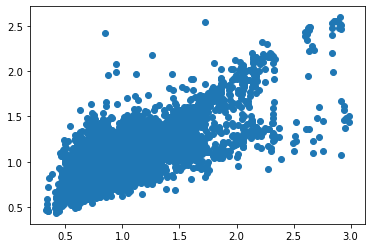

In [56]:
plt.scatter(p_d, p_d_2)
plt.show()

### Ploting Volatility Real Rolling  vs LSTM Forecasted

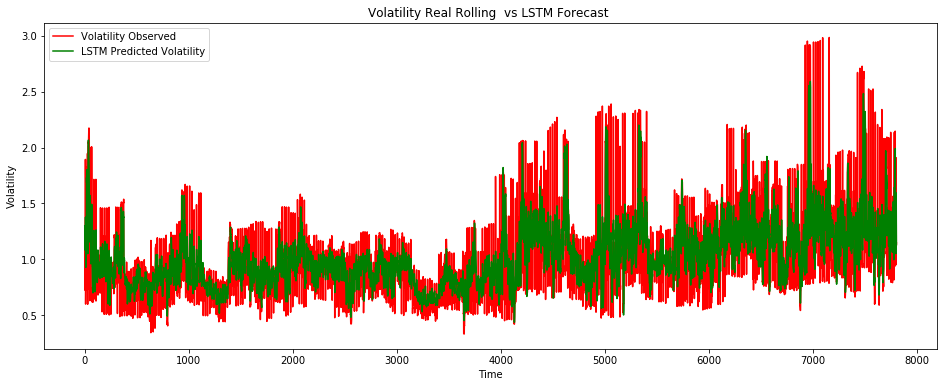

In [57]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(df.iloc[100:, 9:10].values, color = 'red', label = 'Volatility Observed')
plt.plot(predicted_vol, color = 'green', label = 'LSTM Predicted Volatility')
plt.title('Volatility Real Rolling  vs LSTM Forecast ')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Calculating RMSE value for LSTM Model

In [58]:
 print('RMSE calculated for LSTM model:', np.sqrt(metrics.mean_squared_error(df.iloc[100:, 9:10].values, predicted_vol)))


RMSE calculated for LSTM model: 0.22848766799056894


In [59]:
print('MAE calculated for LSTM model:', MAE(df.iloc[100:, 9:10].values, predicted_vol))

MAE calculated for LSTM model: 0.14523580690482635


In [60]:
print('MAPE calculated for LSTM model:',mean_absolute_percentage_error(df.iloc[100:, 9:10], predicted_vol))

MAPE calculated for LSTM model: 0.15215893457196775


## Volatility Prediction using Monte Carlo Simulation

In [44]:
returns_M = df['Volatility']

In [45]:
last_Close = df.Volatility[-1]

### Number of Simulations

In [61]:
num_simulations = 10
num_days = 252

In [62]:
simulation_df = pd.DataFrame()
for x in range(num_simulations):
    count = 0
    daily_vol = returns_M.std()
    
    price_series = []
    
    price = last_Close * (1 + np.random.normal(0, daily_vol))
    price_series.append(price)
    
    for y in range(num_days):
        if count == 251:
            break
        price = price_series[count] * (1 + np.random.normal(0, daily_vol))
        price_series.append(price)
        count += 1
    
    simulation_df[x] = price_series

In [63]:
MC_a=df['Volatility'].head(252)

In [64]:
MC_a.to_excel('MC_a.xlsx') # to export actual values of MC MODEL

In [65]:
simulation_df.to_excel('MC.xlsx') # FOR TOP 252 DAYS PREDICTED VALUE USING MC

### Ploting Monte Carlo Volatility

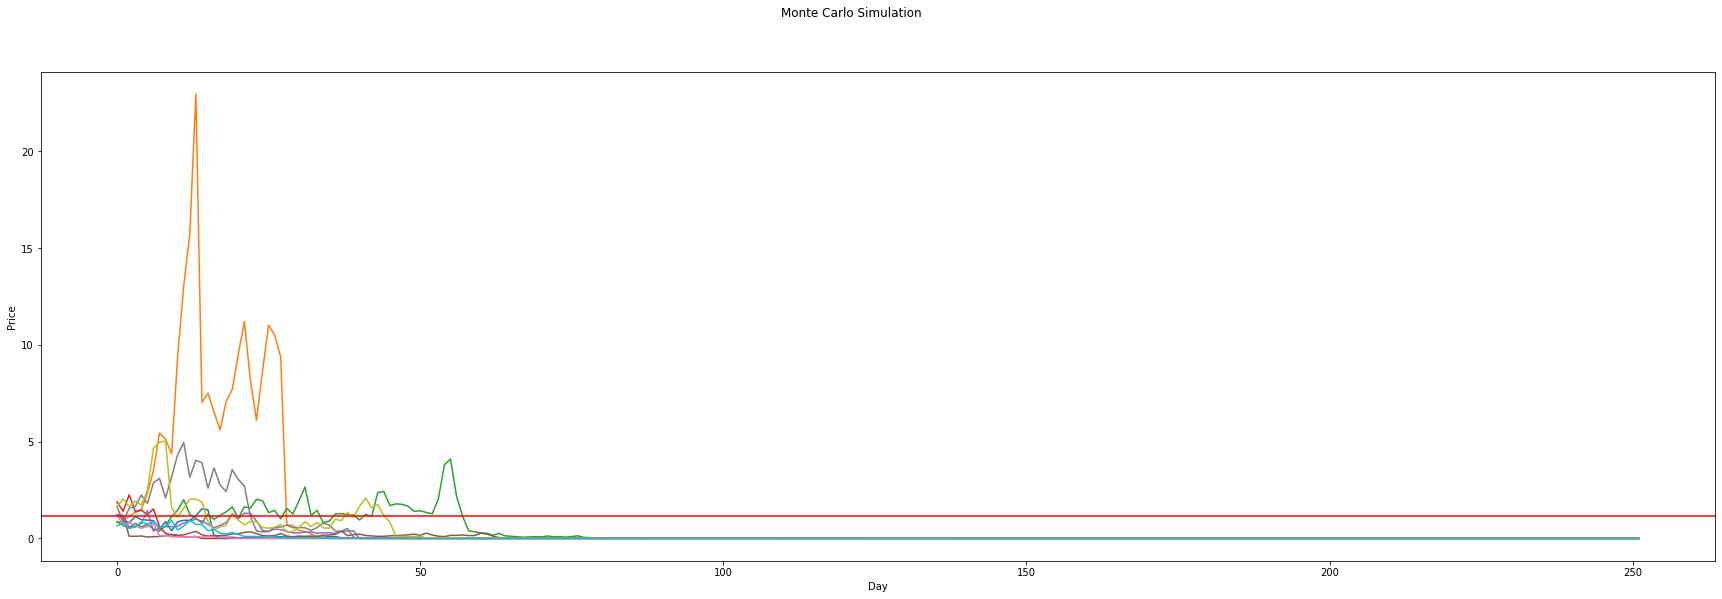

In [66]:
fig = plt.figure(figsize=(30,9))
fig.suptitle('Monte Carlo Simulation')
plt.plot(simulation_df)
plt.axhline(y = last_Close, color = 'r', linestyle = '-')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [67]:
print('RMSE calculated for MC model:', np.sqrt(metrics.mean_squared_error(df.iloc[0:252:, 9:10].values,  simulation_df[0])))

RMSE calculated for MC model: 1.1313226097206652


In [68]:
print('MAE calculated for MC model:',MAE(df.iloc[0:252, 9:10].values, simulation_df[0]))

MAE calculated for MC model: 1.0390442943622413


In [69]:
print('MAPE calculated for SVM model:',mean_absolute_percentage_error(df.iloc[0:252, 9:10].values, simulation_df[0]))

MAPE calculated for SVM model: 0.9489246039803005


## Volatility Prediction Using SVM

### Preparing testing and training dataset

In [70]:
training_set = df.iloc[:, 9:10].values
X_tr = []
y_tr = []
for i in range(10, df.shape[0]):
    X_tr.append(training_set[i-10:i,0])
    y_tr.append(training_set[i,0])
X_tr, y_tr = np.array(X_tr), np.array(y_tr)

#### RBF model

In [71]:
svr_rbf = SVR(kernel='rbf',C=0.5,gamma=5, epsilon=0.01)
#svr_rbf = SVR(kernel='rbf', C=1000, gamma=8)

In [77]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svr_rbf, parameters)

In [94]:
y_rbf = clf.fit(X_tr,y_tr).predict(X_tr)

In [78]:
#y_rbf = svr_rbf.fit(X_tr,y_tr).predict(X_tr)

In [95]:
clf.get_params()

{'cv': None,
 'error_score': nan,
 'estimator': SVR(C=0.5, epsilon=0.01, gamma=5),
 'estimator__C': 0.5,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.01,
 'estimator__gamma': 5,
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'n_jobs': None,
 'param_grid': {'C': [1, 10], 'kernel': ('linear', 'rbf')},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [96]:
predicted_vol_rbf = np.exp(y_rbf)

In [97]:
print(metrics.r2_score(y_tr, y_rbf))

0.5125068597200597


#### Linear model

In [98]:
svr_linear = SVR(kernel='linear',C=0.5, gamma=5, epsilon=0.01)

In [99]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf1 = GridSearchCV(svr_linear, parameters)

In [100]:
clf1.get_params()

{'cv': None,
 'error_score': nan,
 'estimator': SVR(C=0.5, epsilon=0.01, gamma=5, kernel='linear'),
 'estimator__C': 0.5,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.01,
 'estimator__gamma': 5,
 'estimator__kernel': 'linear',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'n_jobs': None,
 'param_grid': {'C': [1, 10], 'kernel': ('linear', 'rbf')},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [101]:
y_linear = svr_linear.fit(X_tr,y_tr).predict(X_tr)

In [102]:
clf1.score(X_tr, y_tr)

NotFittedError: ignored

In [103]:
predicted_vol_linear = np.exp(y_linear)

In [104]:
p_d_s_o = pd.DataFrame(df.iloc[10:, 9:10].values)

In [105]:
p_d_s_R = pd.DataFrame(predicted_vol_rbf)

In [106]:
p_d_s_l = pd.DataFrame(predicted_vol_linear)

In [107]:
p_d_s_o = pd.DataFrame(df.iloc[10:, 9:10].values) # ACTUAL VALUES

In [108]:
p_d_s_o.to_excel('SVR_A.xlsx') # prints actual values

In [109]:
p_d_s_R.to_excel('SVR_r_p.xlsx') #PRINT RBF SVR VALUE FORECAST

In [110]:
p_d_s_l.to_excel('SVR_l_p.xlsx')#pRINT LINEAR SVR VALUE FORECAST

In [111]:
p_d_s_l.head(20)

,0
0,3.447044
1,4.959959
2,2.887305
3,2.088317
4,2.787042
5,2.916848
6,3.027782
7,3.056791
8,3.158404
9,3.136218


#### Polynomial Model

In [ ]:
#svr_poly = SVR(kernel = 'poly',C=10)

In [ ]:
#y_poly = svr_poly.fit(X_tr,y_tr).predict(X_tr)

In [ ]:
#predicted_vol_poly = np.exp(y_poly)

### Ploting Volatility Observed, predicted Volatility using RBF,predicted Volatility using Linear SVR

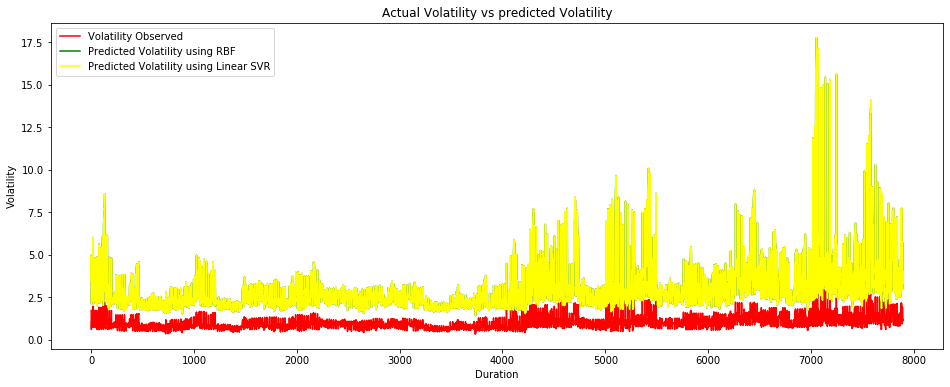

In [112]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(df.iloc[10:, 9:10].values, color = 'red', label = 'Volatility Observed')
plt.plot(predicted_vol_rbf, color = 'green', label = 'Predicted Volatility using RBF')
plt.plot(predicted_vol_linear, color = 'yellow', label = 'Predicted Volatility using Linear SVR')
#plt.plot(predicted_vol, color = 'green', label = 'LSTM Predicted Volatility')
plt.title('Actual Volatility vs predicted Volatility')
plt.xlabel('Duration')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Calculating RMSE value for SVM Model

In [113]:
print('RMSE calculated for SVM:', np.sqrt(metrics.mean_squared_error(df.iloc[10:, 9:10].values, predicted_vol_linear)))

RMSE calculated for SVM: 2.267500742160809


In [114]:
print('RMSE calculated for SVM:', np.sqrt(metrics.mean_squared_error(df.iloc[10:, 9:10].values, y_rbf)))

RMSE calculated for SVM: 0.26141590921390484


In [115]:
print('MAE calculated for SVM model:', MAE(df.iloc[10:, 9:10].values, predicted_vol_linear))

MAE calculated for SVM model: 1.9220780992946964


In [116]:
print('MAE calculated for SVM model:',MAE(df.iloc[10:, 9:10].values, y_rbf))

MAE calculated for SVM model: 0.1411609940960886


In [117]:
print('MAPE calculated for SVM model:',mean_absolute_percentage_error(df.iloc[10:, 9:10].values, predicted_vol_linear))

MAPE calculated for SVM model: 1.979325987561185


In [118]:
print('MAPE calculated for SVM model:',mean_absolute_percentage_error(df.iloc[10:, 9:10].values,y_rbf))

MAPE calculated for SVM model: 0.1420415745779379


## Volatility Prediction using Random Forest

#### Create Random Forest Regressor Model

In [121]:
ran_mod = RandomForestRegressor(n_estimators=30, verbose=2, random_state=42, n_jobs = -1)

NameError: ignored

In [123]:
rand_mod = ran_mod.fit(X_tr, y_tr)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30building tree 18 of 30

building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30building tree 26 of 30

building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.9s finished


In [124]:
rand_mod.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 30,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}

In [125]:
rand_mod.score(X_tr, y_tr)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


0.9365544551795635

### Predicted Volatility

In [126]:
predicted_vol_rand = rand_mod.predict(X_tr)
predicted_vol_rand

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


array([1.59919833, 1.02159806, 0.71887465, ..., 1.58082544, 1.25429872,
       1.13257875])

In [127]:
p_d_For = pd.DataFrame(predicted_vol_rand)

In [128]:
p_d_For.to_excel('rand_For_p.xlsx')#PRINT PREDICTED VALUE

In [129]:
p_d_s_o.to_excel('rand_For_a.xlsx')#PRINT ACTUAL VALUE

In [130]:
p_d_For

,0
0,1.599198
1,1.021598
2,0.718875
3,1.012547
4,1.006295
...,...
7889,1.140511
7890,1.638066
7891,1.580825
7892,1.254299


### Ploting Volatility Observed, predicted Volatility using Random Forest

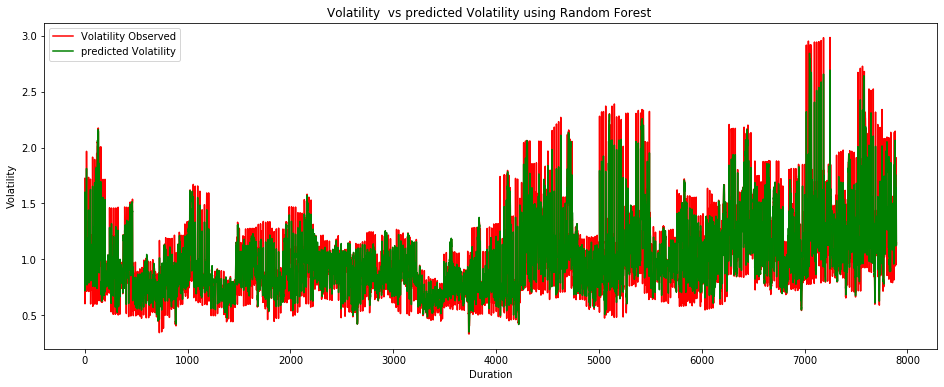

In [131]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(df.iloc[10:, 9:10].values, color = 'red', label = 'Volatility Observed')
plt.plot(predicted_vol_rand, color = 'green', label = 'predicted Volatility')
plt.title('Volatility  vs predicted Volatility using Random Forest ')
plt.xlabel('Duration')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Calculating RMSE value for Random Forest Model

In [132]:
print('RMSE calculated for Random Forest:', np.sqrt(metrics.mean_squared_error(df.iloc[10:, 9:10].values, predicted_vol_rand)))

RMSE calculated for Random Forest: 0.09430795451758997


In [133]:
print('MAE calculated for  Random Forest:',MAE(df.iloc[10:, 9:10].values, predicted_vol_rand))

MAE calculated for  Random Forest: 0.05673429506632631


In [134]:
print('MAPE calculated for Random Forest:',mean_absolute_percentage_error(y_rbf,  predicted_vol_rand))

MAPE calculated for Random Forest: 0.10553549849857646
